In [1]:
# hate_speech_detection.py

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer

import joblib  # For saving Tokenizer

In [7]:
# Load the cleaned dataset
df = pd.read_csv("cleaned_twitter_data.csv")

# Display the first few rows
print("Initial Data:")
print(df.head())

df.drop("username", axis = 1, inplace=True)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop missing values if any
df.dropna(inplace=True)

# Encode labels
label_mapping = {
    "Neutral or Ambiguous": 0,
    "Offensive or Hate Speech": 1,
    "Not Hate": 2
}
df["labels_encoded"] = df["labels"].map(label_mapping)

# Save the label mapping for later use
label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])
joblib.dump(label_encoder, 'label_encoder.pkl')

Initial Data:
          username                                              tweet  \
0    @mayasolovely  RT As a woman you shouldnt complain about clea...   
1         @mleew17  RT boy dats coldtyga dwn bad for cuffin dat ho...   
2   @UrKindOfBrand  RT Dawg RT You ever fuck a bitch and she start...   
3    @C_G_Anderson                          RT she look like a tranny   
4  @ShenikaRoberts  RT The shit you hear about me might be true or...   

                     labels  
0      Neutral or Ambiguous  
1  Offensive or Hate Speech  
2  Offensive or Hate Speech  
3  Offensive or Hate Speech  
4  Offensive or Hate Speech  

Missing Values:
tweet     0
labels    0
dtype: int64


['label_encoder.pkl']

In [9]:
# Define features and labels
X = df['tweet']
y = df['labels_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 194190, Test samples: 48548


In [10]:
# Hyperparameters
max_vocab_size = 10000
max_sequence_length = 100
embedding_dim = 100
batch_size = 32

# Initialize Tokenizer
tokenizer_lstm = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(X_train)

# Save the tokenizer for later use
joblib.dump(tokenizer_lstm, 'tokenizer_lstm.pkl')

# Convert texts to sequences
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# One-hot encode labels for LSTM models
y_train_lstm = to_categorical(y_train, num_classes=3)
y_test_lstm = to_categorical(y_test, num_classes=3)

In [11]:
def build_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes
    ])
    return model

# Build LSTM model
lstm_model = build_lstm_model(max_vocab_size, embedding_dim, max_sequence_length)

# Compile LSTM model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
print("\nLSTM Model Summary:")
lstm_model.summary()

# Train LSTM model
history_lstm = lstm_model.fit(
    X_train_padded, y_train_lstm,
    batch_size=batch_size,
    epochs=10,
    validation_split=0.2
)

# Save LSTM model
lstm_model.save('lstm_model.h5')

/Users/manojdannana/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 226s 46ms/step - accuracy: 0.6636 - loss: 0.7296 - val_accuracy: 0.7379 - val_loss: 0.5867
Epoch 2/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 227s 47ms/step - accuracy: 0.7687 - loss: 0.5238 - val_accuracy: 0.7665 - val_loss: 0.5371
Epoch 3/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 237s 49ms/step - accuracy: 0.8131 - loss: 0.4328 - val_accuracy: 0.7853 - val_loss: 0.5087
Epoch 4/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 231s 47ms/step - accuracy: 0.8472 - loss: 0.3590 - val_accuracy: 0.7972 - val_loss: 0.4963
Epoch 5/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 236s 49ms/step - accuracy: 0.8747 - loss: 0.2970 - val_accuracy: 0.8106 - val_loss: 0.5044
Epoch 6/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 233s 48ms/step - accuracy: 0.8957 - loss: 0.2549 - val_accuracy: 0.8169 - val_loss: 0.5170
Epoch 7/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 233s 48ms/step - accuracy: 0.9131 - loss: 0.2132 - val_accuracy: 0.8290 - val_loss: 0.5263
Epoch 8/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 234s 48ms/step - accuracy: 

In [12]:
lstm_model.save("lstm.keras")

In [13]:
def build_lstm_cnn_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes
    ])
    return model

# Build LSTM + CNN model
lstm_cnn_model = build_lstm_cnn_model(max_vocab_size, embedding_dim, max_sequence_length)

# Compile LSTM + CNN model
lstm_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
print("\nLSTM + CNN Model Summary:")
lstm_cnn_model.summary()

# Train LSTM + CNN model
history_lstm_cnn = lstm_cnn_model.fit(
    X_train_padded, y_train_lstm,
    batch_size=batch_size,
    epochs=10,
    validation_split=0.2
)

# Save LSTM + CNN model
lstm_cnn_model.save('lstm_cnn_model.h5')


LSTM + CNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 286s 59ms/step - accuracy: 0.6580 - loss: 0.7442 - val_accuracy: 0.7349 - val_loss: 0.5788
Epoch 2/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 313s 64ms/step - accuracy: 0.7686 - loss: 0.5275 - val_accuracy: 0.7712 - val_loss: 0.5189
Epoch 3/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 327s 67ms/step - accuracy: 0.8182 - loss: 0.4269 - val_accuracy: 0.7868 - val_loss: 0.5015
Epoch 4/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 330s 68ms/step - accuracy: 0.8566 - loss: 0.3435 - val_accuracy: 0.8073 - val_loss: 0.5129
Epoch 5/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 340s 70ms/step - accuracy: 0.8873 - loss: 0.2720 - val_accuracy: 0.8205 - val_loss: 0.5269
Epoch 6/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 314s 65ms/step - accuracy: 0.9093 - loss: 0.2171 - val_accuracy: 0.8285 - val_loss: 0.6316
Epoch 7/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 312s 64ms/step - accuracy: 0.9279 - loss: 0.1809 - val_accuracy: 0.8397 - val_loss: 0.6087
Epoch 8/10
4855/4855 ━━━━━━━━━━━━━━━━━━━━ 325s 67ms/step - accuracy: 

In [20]:
# Initialize BERT tokenizer
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

# Save the tokenizer for later use
tokenizer_bert.save_pretrained('./tokenizer_bert')

# Function to preprocess texts for BERT
def preprocess_texts_bert(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

# Preprocess training and testing data
train_encodings = preprocess_texts_bert(X_train, tokenizer_bert, max_length=128)
test_encodings = preprocess_texts_bert(X_test, tokenizer_bert, max_length=128)

# Convert labels to TensorFlow tensors (integers for SparseCategoricalCrossentropy)
y_train_bert = y_train.values
y_test_bert = y_test.values

# Load BERT model for classification
bert_model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3
)

# Define optimizer using Hugging Face's create_optimizer
epochs = 3
learning_rate = 5e-5
batch_size_bert = 16
num_train_steps = len(train_encodings["input_ids"]) // batch_size_bert * epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

# Compile BERT model
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Train BERT model
history_bert = bert_model.fit(
    x={"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y=y_train_bert,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size_bert
)

# Save BERT model

Epoch 1/3
1233/1233 [==============================] - 6711s 5s/step - loss: 0.4949 - accuracy: 0.7884 - val_loss: 0.3357 - val_accuracy: 0.8719
Epoch 2/3
1233/1233 [==============================] - 3370s 3s/step - loss: 0.2420 - accuracy: 0.9105 - val_loss: 0.2602 - val_accuracy: 0.9088
Epoch 3/3
1233/1233 [==============================] - 3221s 3s/step - loss: 0.0907 - accuracy: 0.9707 - val_loss: 0.2745 - val_accuracy: 0.9217


In [38]:
from transformers import TFBertForSequenceClassification, BertTokenizer

# Example of saving the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Save the model and tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json')


Evaluating LSTM Model:
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8479 - loss: 0.5901
Test Loss: 0.5864, Test Accuracy: 0.8478
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step


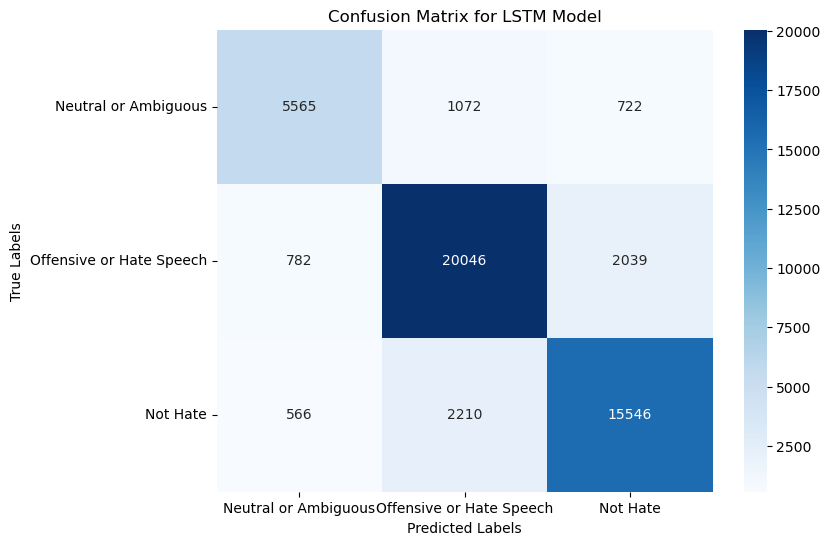


Classification Report for LSTM Model:
                          precision    recall  f1-score   support

    Neutral or Ambiguous       0.81      0.76      0.78      7359
Offensive or Hate Speech       0.86      0.88      0.87     22867
                Not Hate       0.85      0.85      0.85     18322

                accuracy                           0.85     48548
               macro avg       0.84      0.83      0.83     48548
            weighted avg       0.85      0.85      0.85     48548

ROC-AUC Score for LSTM Model: 0.9425

Evaluating LSTM+CNN Model:
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8563 - loss: 0.7906
Test Loss: 0.7759, Test Accuracy: 0.8561
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step


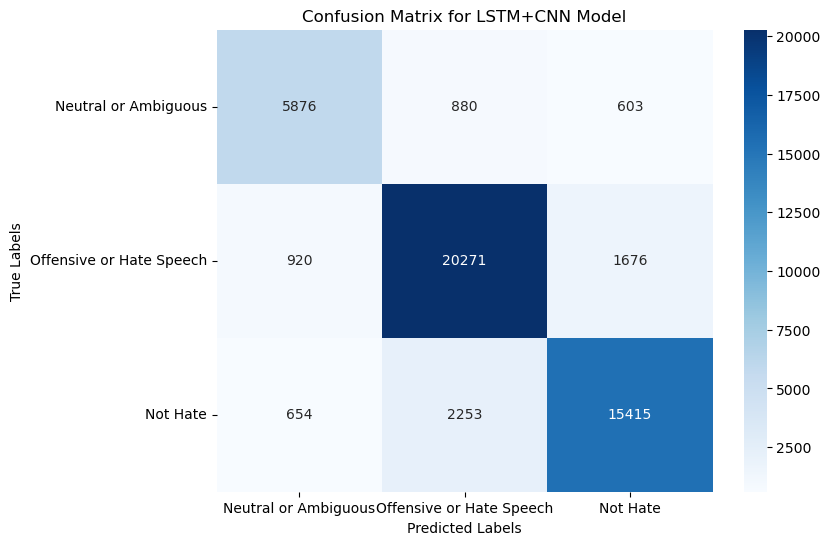


Classification Report for LSTM+CNN Model:
                          precision    recall  f1-score   support

    Neutral or Ambiguous       0.79      0.80      0.79      7359
Offensive or Hate Speech       0.87      0.89      0.88     22867
                Not Hate       0.87      0.84      0.86     18322

                accuracy                           0.86     48548
               macro avg       0.84      0.84      0.84     48548
            weighted avg       0.86      0.86      0.86     48548

ROC-AUC Score for LSTM+CNN Model: 0.9466


In [14]:
def evaluate_model(model, X_test, y_test, model_type='LSTM'):
    print(f"\nEvaluating {model_type} Model:")
    if model_type in ['LSTM', 'LSTM+CNN']:
        loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
        
        # Predictions
        y_pred_probs = model.predict(X_test, batch_size=32)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
    elif model_type == 'BERT':
        loss, accuracy = model.evaluate(
            x={"input_ids": X_test["input_ids"], "attention_mask": X_test["attention_mask"]},
            y=y_test,
            batch_size=16
        )
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
        
        # Predictions
        y_pred_probs = model.predict(
            x={"input_ids": X_test["input_ids"], "attention_mask": X_test["attention_mask"]}
        ).logits
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = y_test
    else:
        raise ValueError("Invalid model type. Choose from 'LSTM', 'LSTM+CNN', 'BERT'.")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_mapping.keys(),
                yticklabels=label_mapping.keys())
    plt.title(f'Confusion Matrix for {model_type} Model')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    
    # Classification Report
    print(f"\nClassification Report for {model_type} Model:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_mapping.keys()))
    
    # ROC-AUC Score
    if len(label_mapping) > 2:
        # One-hot encode y_true_classes for ROC-AUC
        y_true_binary = to_categorical(y_true_classes, num_classes=3)
        roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_true_classes, y_pred_probs[:, 1])
    
    print(f"ROC-AUC Score for {model_type} Model: {roc_auc:.4f}")
    return accuracy, roc_auc

# Evaluate LSTM
accuracy_lstm, roc_auc_lstm = evaluate_model(lstm_model, X_test_padded, y_test_lstm, model_type='LSTM')

# Evaluate LSTM + CNN
accuracy_lstm_cnn, roc_auc_lstm_cnn = evaluate_model(lstm_cnn_model, X_test_padded, y_test_lstm, model_type='LSTM+CNN')

# Evaluate BERT
# accuracy_bert, roc_auc_bert = evaluate_model(bert_model, test_encodings, y_test_bert, model_type='BERT')


In [15]:
# Compare ROC-AUC scores to select the best model
roc_auc_scores = {
    'LSTM': roc_auc_lstm,
    'LSTM+CNN': roc_auc_lstm_cnn,
}

best_model_name = max(roc_auc_scores, key=roc_auc_scores.get)
print(f"\nBest Model based on ROC-AUC: {best_model_name}")

# Save the best model name for Flask app
with open('best_model.txt', 'w') as f:
    f.write(best_model_name)


Best Model based on ROC-AUC: LSTM+CNN


In [18]:
def predict_unseen_text(model, tokenizer, text, model_type='LSTM'):
    if model_type in ['LSTM', 'LSTM+CNN']:
        # Load tokenizer
        tokenizer = joblib.load('tokenizer_lstm.pkl')
        
        # Preprocess
        sequence = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
        
        # Predict
        pred_probs = model.predict(padded)
        pred_class = np.argmax(pred_probs, axis=1)[0]
    
    elif model_type == 'BERT':
        # Preprocess using BERT tokenizer
        encodings = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="tf")
        
        # Predict
        logits = model.predict(encodings).logits
        pred_class = tf.argmax(logits, axis=1).numpy()[0]
    
    else:
        raise ValueError("Invalid model type. Choose from 'LSTM', 'LSTM+CNN', 'BERT'.")
    
    # Map to label
    label = list(label_mapping.keys())[list(label_mapping.values()).index(pred_class)]
    return label

# Example usage
unseen_texts = [
    "I completely disagree with this view!",
    "What a beautiful day!",
    "You are absolutely horrible and disgusting piece of shit and a whore!"
]

best_model = None
if best_model_name == 'LSTM':
    best_model = lstm_model
elif best_model_name == 'LSTM+CNN':
    best_model = lstm_cnn_model
elif best_model_name == 'BERT':
    best_model = bert_model

print("\nPredictions on Unseen Texts:")
for text in unseen_texts:
    prediction = predict_unseen_text(best_model, tokenizer_lstm, text, model_type=best_model_name)
    print(f"Text: \"{text}\" -> Prediction: {prediction}")


Predictions on Unseen Texts:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Text: "I completely disagree with this view!" -> Prediction: Not Hate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Text: "What a beautiful day!" -> Prediction: Not Hate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Text: "You are absolutely horrible and disgusting piece of shit and a whore!" -> Prediction: Offensive or Hate Speech
